# Finding the best "hygge" path 🏞️

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from random import choice

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Data
### Bike paths
To get the bike paths, we use _OpenStreetMap_ with the library `osmnx`. We query OSM with the _Københavns Kommune_ and _Frederiksberg Kommune_ geocodes. We specify `network_type='bike'` to strictly get bike paths. Since the streets are danish, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [2]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

# remove lists from highways, take the first element if list
edges['highway'] = edges.highway.apply(lambda x: x[0] if isinstance(x, list) else x)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


### Bird attributes
Bird data is extracted in the [`bird-edges.ipynb`](/notebooks/bird-edges.ipynb) notebook. Birds are attributed to an edge if a 50m buffer around the bird intersects with a given street.

In [3]:
birds = pd.read_csv('../data/bird_edges.csv').set_index(['u', 'v', 'key'])
birds.head()

birds  birds_per_m
u          v          key                    
118725     298795432  0      8.0     0.070877
           6357644306 0      3.0     0.074080
298795432  298795496  0      7.0     0.077950
6357644306 2378383724 0      2.0     0.091199
           6357644350 0      1.0     0.043373

### Tree attributes
Tree data is extracted in the [`tree-edges.ipynb`](/notebooks/tree-edges.ipynb) notebook. Trees are assigned to the nearest road with a maximum distance of 10m. Each tree is assigned to at most 1 street.

In [4]:
trees = pd.read_csv('../data/tree_edges.csv').set_index(['u', 'v', 'key'])
trees.head()

trees  trees_per_m
u          v          key                    
118725     298795432  0      0.0          0.0
           6357644306 0      0.0          0.0
298795432  298795496  0      0.0          0.0
6357644306 2378383724 0      0.0          0.0
           6357644350 0      0.0          0.0

### Traffic noise attributes
![image.png](../pictures/noise.png)

### Putting it all together
Once all the individual data parts are loaded, they are joined into a single dataframe.

In [5]:
gdf = edges
gdf = gdf.merge(birds, right_index=True, left_index=True, how='left')
gdf = gdf.merge(trees, right_index=True, left_index=True, how='left')
... # noise

Ellipsis

In [6]:
gdf.head()

osmid  oneway              name   highway  \
u          v          key                                                  
118725     298795432  0     27226011    True  Banegårdspladsen  tertiary   
           6357644306 0    140412993    True     Vesterbrogade  tertiary   
298795432  298795496  0    244360867    True  Banegårdspladsen  tertiary   
6357644306 2378383724 0    678991574    True     Vesterbrogade  tertiary   
           6357644350 0    679140293    True     Vesterbrogade  tertiary   

                          maxspeed   length  \
u          v          key                     
118725     298795432  0         30  112.872   
           6357644306 0         50   40.497   
298795432  298795496  0         30   89.801   
6357644306 2378383724 0         50   21.930   
           6357644350 0         50   23.056   

                                                                    geometry  \
u          v          key                                                      
118725     298795432  0    LINESTRING (724025.025 6175551.339, 724031.889...   
           6357644306 0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432  298795496  0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306 2378383724 0    LINESTRING (724059.919 6175572.112, 724075.704...   
           6357644350 0    LINESTRING (724059.919 6175572.112, 724081.508...   

                          lanes bridge  ref service width access tunnel  \
u          v          key                                                 
118725     298795432  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644306 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
298795432  298795496  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
6357644306 2378383724 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644350 0       1    NaN  NaN     NaN   NaN    NaN    NaN   

                          junction  birds  birds_per_m  trees  trees_per_m  
u          v          key                                                   
118725     298795432  0        NaN    8.0     0.070877    0.0          0.0  
           6357644306 0        NaN    3.0     0.074080    0.0          0.0  
298795432  298795496  0        NaN    7.0     0.077950    0.0          0.0  
6357644306 2378383724 0        NaN    2.0     0.091199    0.0          0.0  
           6357644350 0        NaN    1.0     0.043373    0.0          0.0

## Finding the best "hygge" path
While there are many applicable approaches for this sort of specialized shortest path algorithm, we demonstrate one of the simplest implementations. The implemented approach categorizes each feature, and boosts or penalizes the road length according to a manually set factor, based on how _hyggelig_ we deem the feature to be. For instance, if a path contains a lot of bird observations, we shorten the length of the path to encourage bikers to use it. However, if there is a lot of traffic noise at a path, we lengthen the path by some factor to discourage it. 

$$
d_{hygge} = d \prod_{i=1}^{|w|} w_i, \;\;\;\forall w \in \{w_1, w_2, \ldots, w_n\}
$$

For this, we will use information about birds, trees, noise, and general OSM data.

### Weighting birds


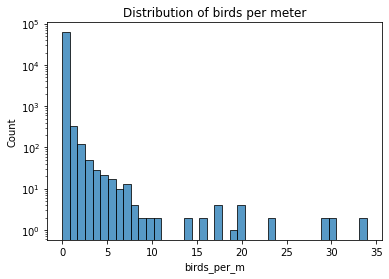

In [7]:
f, ax = plt.subplots()
sns.histplot(data=gdf, x='birds_per_m', ax=ax, bins=40)
ax.set_yscale('log')
ax.set_title('Distribution of birds per meter');

In [8]:
bins = [0, 0.8, 0.9, 1]
labels = ['no birds?', 'some birds', 'HOLY SHIT THAT IS A LOT OF BIRDS']
w_map = {
    'no birds?': 1,
    'some birds': 0.7, 
    'HOLY SHIT THAT IS A LOT OF BIRDS': 0.5
}
gdf['birds_per_m_cat'] = pd.cut(gdf.birds_per_m, gdf.birds_per_m.quantile(bins), include_lowest=True, labels=labels)
gdf['birds_per_m_w'] = gdf.birds_per_m_cat.map(w_map).astype(float)

### Weighting trees

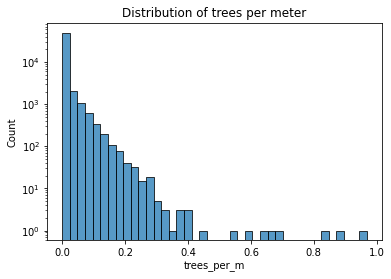

In [9]:
f, ax = plt.subplots()
sns.histplot(data=gdf, x='trees_per_m', ax=ax, bins=40)
ax.set_yscale('log')
ax.set_title('Distribution of trees per meter');

In [10]:
bins = [0, 0.9, 1]
labels = ['no trees?', 'HOLY SHIT THAT IS A LOT OF TREES']
w_map = {
    'no trees?': 1,
    'HOLY SHIT THAT IS A LOT OF TREES': 0.7
}
gdf['trees_per_m_cat'] = pd.cut(gdf.trees_per_m, gdf.trees_per_m.quantile(bins), include_lowest=True, labels=labels)
gdf['trees_per_m_w'] = gdf.trees_per_m_cat.map(w_map).astype(float)

### Weighting noise

In [11]:
...

Ellipsis

### Weighting OSM data 

In [12]:
...

Ellipsis

### Modified hygge length

In [13]:
gdf['hyggelength'] = gdf['length'] * gdf['birds_per_m_w'] * gdf['trees_per_m_w']

In [14]:
G = ox.graph_from_gdfs(nodes, gdf[gdf.trees.notna()])

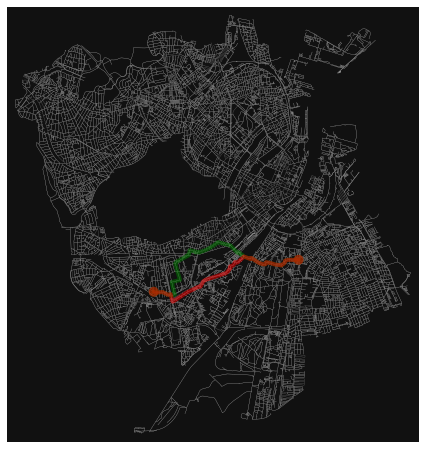

hygge path
hygge : 4676.90307
length: 6645.479

length path
hygge : 4820.00104
length: 5625.475000000001



In [15]:
#orig = choice(list(G.nodes))
#dest = choice(list(G.nodes))

orig = 1783390939
dest = 11807672519

route_hygge = ox.shortest_path(G, orig, dest, weight='hyggelength')
route_length = ox.shortest_path(G, orig, dest, weight='length')
routes = [route_hygge, route_length]
route_labels = ['hygge path', 'length path']
f, ax = ox.plot_graph_routes(
    G, 
    routes, 
    node_alpha=0, 
    edge_linewidth=0.2,
    route_colors=['green', 'red']
)

for route, label in zip(routes, route_labels):
    print(label)
    print('hygge :', nx.path_weight(G, route, weight='hyggelength'))
    print('length:', nx.path_weight(G, route, weight='length'))
    print()

### Extra hygge hygge analysis

#### Clustering of hygge paths
Using all the different hygge features, we can cluster paths that are similar in the hygge dimension.

In [16]:
gdf['highway'] = gdf.highway.apply(lambda x: x[0] if isinstance(x, list) else x)

In [17]:
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['highway'])
], remainder='passthrough', sparse_threshold=0)

pipeline = Pipeline([
    ('onehot', ct),
    ('standard', StandardScaler())
])
X = pipeline.fit_transform(gdf[['highway', 'birds_per_m', 'trees_per_m']])

mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]

In [18]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X)

In [19]:
tsne = TSNE()
X_2d = tsne.fit_transform(X)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


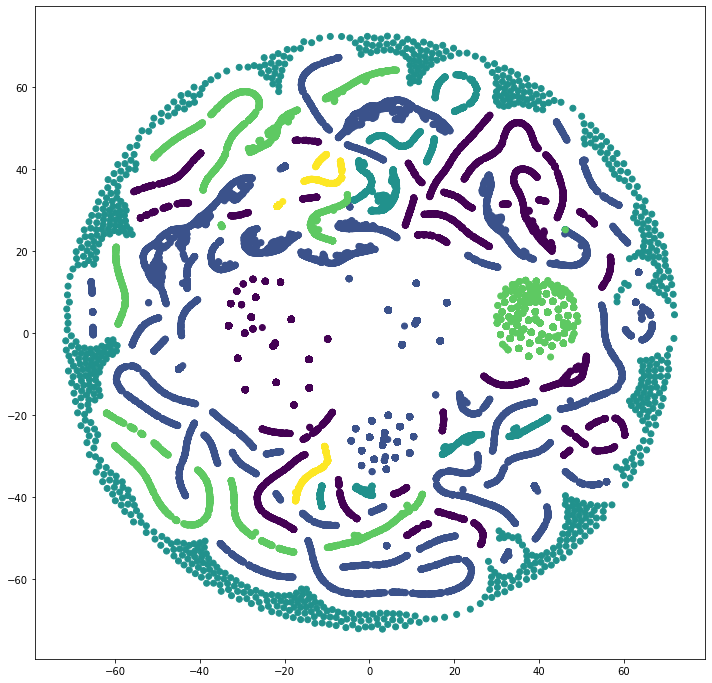

In [20]:
f, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_2d[:,0], X_2d[:,1], c=clusters)

In [21]:
xgdf = gdf[mask]
xgdf['cluster'] = clusters

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


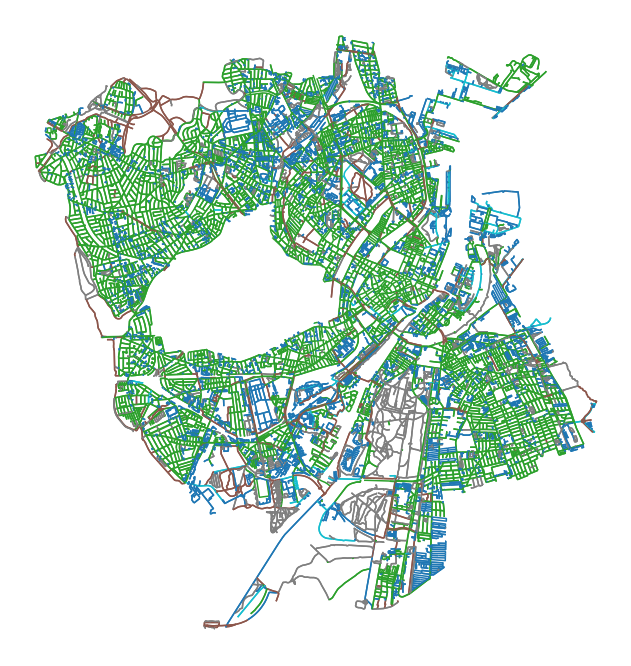

In [22]:
f, ax = plt.subplots(figsize=(12,12))
xgdf.plot(column='cluster', ax=ax, cmap='tab10')
ax.set_axis_off()

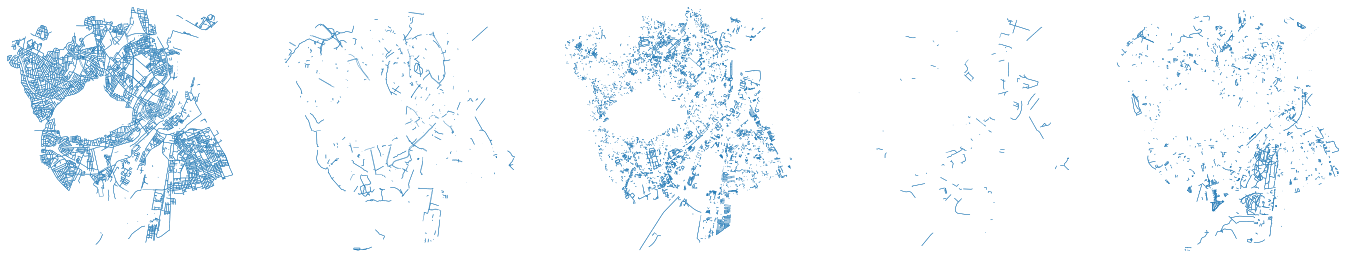

In [23]:
unique_clusters = xgdf.cluster.unique()
N = xgdf.cluster.nunique()

bounds = xgdf.total_bounds

f, axes = plt.subplots(1, N, figsize=(24,24))

for i, c in enumerate(unique_clusters):
    ax = axes[i]
    mask = xgdf.cluster == c
    xgdf[mask].plot(ax=ax, linewidth=0.4)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_axis_off()

In [24]:
silhouette_score(X, clusters)

0.500366416605014

#### Categorical hygge bike path plot with labeled birds and trees

In [25]:
features = ['birds_per_m', 'trees_per_m']
for feature in features:
    quant = gdf[feature].quantile(0.9)
    gdf[feature + '_cat'] = gdf[feature].apply(lambda x: x > quant)

features_cat = [feature + '_cat' for feature in features]
gdf['super_hygge'] = gdf[features_cat].all(axis=1)

In [26]:
def assign_label(x):
    if x['super_hygge']:
        return 'super_hygge'
    if x['trees_per_m_cat']:
        return 'tree'
    if x['birds_per_m_cat']:
        return 'bird'
    else:
        return 'lortevej'
         
gdf['hygge_cat'] = gdf.apply(assign_label, axis=1)

In [27]:
hygge_alpha = {
    'super_hygge': 1,
    'bird': 0.3,
    'tree': 0.3,
    'lortevej': 0.2
}

hygge_color = {
    'super_hygge': '#c00',
    'bird': '#060',
    'tree': '#00a',
    'lortevej': 'grey'
}

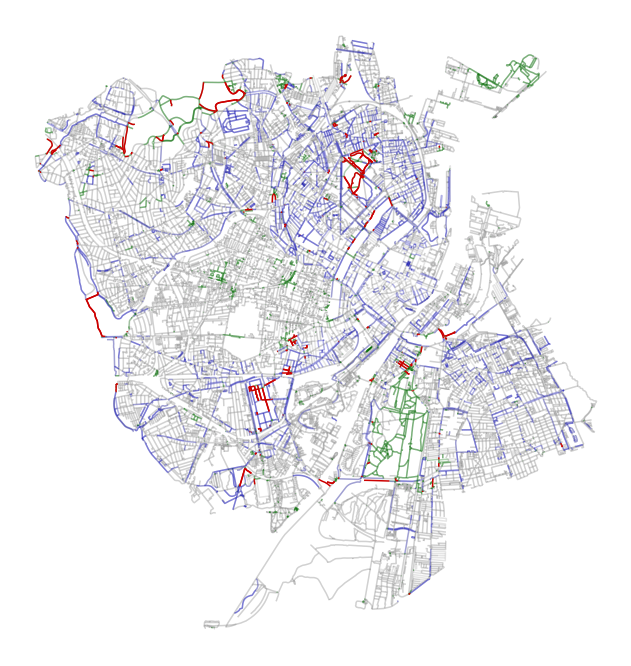

In [28]:
f, ax = plt.subplots(figsize=(12, 12))

for hygge_cat in gdf.hygge_cat.unique():
    gdf[gdf.hygge_cat==hygge_cat].plot(
        color=hygge_color[hygge_cat],
        alpha=hygge_alpha[hygge_cat],
        ax=ax)
ax.set_axis_off()

#### Paths colored by highway

residential red
service yellow
tertiary green
path blue
cycleway orange


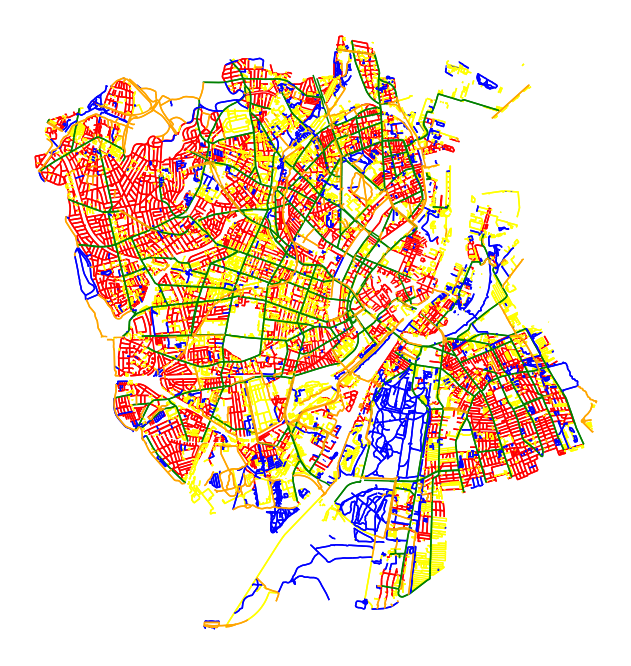

In [29]:
X = gdf
X['highway'] = X.highway.str.split(',').str.join(' ')

f, ax = plt.subplots(figsize=(12,12))
colors = ['red', 'yellow', 'green', 'blue', 'orange']
for i, (key, val) in enumerate(dict(X.highway.value_counts()).items()):
    if i == 5:
        break
    print(key, colors[i])
    X[X.highway == key].plot(ax=ax, color=colors[i], legend=True)
ax.set_axis_off()